# UMAP GUIDE TODO
## SUBTITLE TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@arthousestudio?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>ArtHouse Studio</a>
        on 
        <a href='https://www.pexels.com/photo/wood-man-people-art-4905089/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'></a>
    </strong>
</figcaption>

# Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

# Introduction

No matter how powerful machine learning models are, they can't quite beat the feeling you get during those "Aha!" moments of exploring data through rich visuals. But, there are so many histograms, scatterplots, heatmaps you can create before you say, "this is really getting old".

In those moments, you need something that reminds you of how amazing and mesmerizing data can be. You need to get inspiration from masterpiece visuals like on FlowingData or relevant subreddits, but you don't have to go that far. Recently, I have been fortunate to come across UMAP - a Python package to visualize, cluster high-dimensional data in breathtakingly beautiful ways. It was just what I needed to remember why I got into learning data science 2 years ago. 

Today, we will learn how to analyze multi-dimensional datasets by projecting them to 2D using Uniform Manifold Approximation & Projection (UMAP) package through visuals like below:

TODO

# What is UMAP?

UMAP is a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) algorithm and a powerful data analysis tool.

It is similar to PCA (Principal Component Analysis) in terms of speed and resembles tSNE with its ability to reduce dimensionality while preserving as much information of the dataset as possible. Before UMAP algorithm was introduced in 2018, PCA and tSNE had two biggest flaws:
1) PCA was very fast at the cost of losing finer details of the data after reduction
2) tSNE was extremely slow even though it preserves the underlying structure of the data.

We will talk more about these differences later. Now, it is time to get the first taste of UMAP and we will immediately start with a challenging dataset:

In [2]:
tps = pd.read_csv("data/train.csv").drop("id", axis=1)
tps.head().sample(10, axis=1)

,f71,f100,f101,f39,f46,f12,f99,f61,f58,f3
0,1.32280,0.93416,0.65056,1888.00000,4.56040,1423200000.00000,2.24320,0.51402,-0.35416,-37.56600
1,1.49740,-0.00097,5.29520,4726.50000,4.25230,3334100000.00000,1.27080,0.01161,-0.22629,11822.00000
2,2.58910,0.56095,4.13090,3063.40000,4.10180,1230300000.00000,3.46630,0.02830,-0.16083,907.27000
3,2.15720,0.25020,0.72974,3342.50000,4.48600,1223100000.00000,1.22610,0.13592,-0.39149,780.10000
4,1.34460,0.33953,13.48600,3042.10000,3.91150,2634100000.00000,1.00830,0.46577,-0.98027,-109.15000


In [3]:
tps.shape

(957919, 119)

The Kaggle TPS September dataset contains ~1M rows and ~120 features with a binary target. They are all numerical and we are pretty helpless in terms of performing proper EDA on this dataset. Our options are limited to only printing summary statistics and plotting histograms of individual features. 

Let's see what UMAP can do for us. Before using it, we will sample the dataset to avoid overplotting and fill in the missing values:

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Sample the data
tps_sample = tps.sample(100000)
X, y = tps_sample.drop("claim", axis=1), tps_sample[["claim"]].values.flatten()

# Preprocess
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())

Here, the target represents whether or not a client makes a claim on their insurance. We are using mean-based imputation and Quantile Transformed, which scales features based on quantiles and their medium. This is essential since the dataset contains many skewed and bimodal features.

After [installing](https://umap-learn.readthedocs.io/en/latest/#:~:text=install%20umap-learn-,User%20Guide%20/%20Tutorial%3A,-How%20to%20Use) and importing UMAP, we initialize the manifold algorithm and fit it to `X`, `y` in the familiar Sklearn `fit/transform` pattern:

In [22]:
%%time

import umap  # pip install umap-learn

manifold = umap.UMAP().fit(X, y)
X_reduced = manifold.transform(X)

Wall time: 1min 14s


In [23]:
X_reduced.shape

(100000, 2)

By default, UMAP projects the data to 2 components (2D). Let's create a scatterplot colored by the target class:

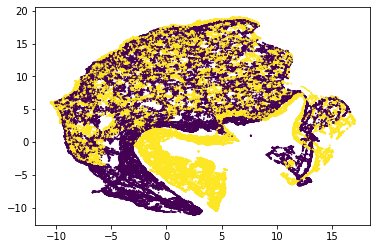

In [24]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

Even though it is fun to look at, the plot does not show any clear patterns. It is probably because we didn't scale the features before fitting UMAP. The algorithm uses distance metrics to group similar data points and features with higher scales tend to bias such calculations. 

So, we will choose Quantile Transformer to scale the features based on their quantiles and median. This scaling method suits the dataset better since it contains many skewed and bimodal features:

In [26]:
%%time

from sklearn.preprocessing import QuantileTransformer

# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)

Wall time: 34.4 s


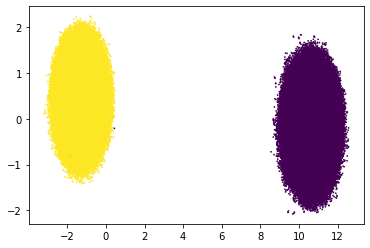

In [27]:
# Plot the results
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

Now, we are talking! UMAP managed to perfectly capture the hidden distinction between the target classes. We can also see some outliers (the dot around the yellow blob). The dataset was not so challenging after all. 

But, this plot is no way close to what I have shown you. It is still overplotted to see structural patterns within each cluster. To take this to the next level, we will use the default UMAP visualization package that comes with much more features. And we will need a better dataset.